In [129]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

In [130]:
import datetime as dt

ticker = input("Enter Stock Symbol: ")
data = yf.download(ticker, start='2010-01-01', end=dt.date.today())
data.head()

Enter Stock Symbol: amzn


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2010-01-04,6.6950,6.8305,6.6570,6.8125,151998000
2010-01-05,6.7345,6.7740,6.5905,6.6715,177038000
2010-01-06,6.6125,6.7365,6.5825,6.7300,143576000
2010-01-07,6.5000,6.6160,6.4400,6.6005,220604000
2010-01-08,6.6760,6.6840,6.4515,6.5280,196610000


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3993 entries, 2010-01-04 to 2025-11-14
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AMZN)   3993 non-null   float64
 1   (High, AMZN)    3993 non-null   float64
 2   (Low, AMZN)     3993 non-null   float64
 3   (Open, AMZN)    3993 non-null   float64
 4   (Volume, AMZN)  3993 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 187.2 KB


In [132]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
count,3993.000000,3993.000000,3993.000000,3993.000000,3.993000e+03
mean,79.382170,80.302821,78.414889,79.402879,8.112429e+07
std,68.075163,68.868356,67.267932,68.114177,5.121445e+07
min,5.430500,5.564500,5.290000,5.296500,1.500750e+07
25%,15.394500,15.582500,15.215500,15.392500,5.046150e+07
50%,58.254002,58.759998,58.000000,58.417999,6.809400e+07
75%,137.940994,139.369995,136.050003,138.300003,9.675400e+07
max,254.000000,258.600006,252.899994,255.360001,8.484220e+08


<Axes: title={'center': 'amzn Close Price'}, xlabel='Date'>

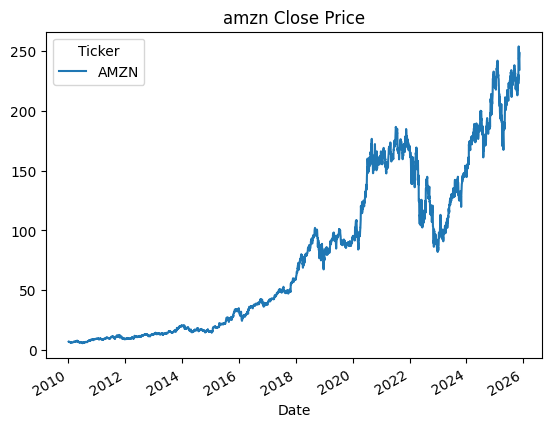

In [133]:
data['Close'].plot(title=f"{ticker} Close Price")

In [134]:
import plotly.graph_objects as go

# Flatten yfinance multi-index columns
data.columns = data.columns.get_level_values(0)

# Reset index to use Date
df = data.reset_index()

# Plot in 1 line
go.Figure(go.Candlestick(
    x=df['Date'], open=df['Open'], high=df['High'],
    low=df['Low'], close=df['Close']
)).update_layout(
    title=f"{ticker} Stock Price",
    xaxis_title="Date", yaxis_title="Price",
    xaxis_rangeslider_visible=False
).show()

In [135]:
# Step 3: Add Simple Features (SMA, EMA, RSI for better accuracy)
# ADD FEATURES
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_50'] = data['Close'].rolling(50).mean()
data['EMA_12'] = data['Close'].ewm(span=12).mean()
data['EMA_26'] = data['Close'].ewm(span=26).mean()

delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

In [136]:
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['MACD_Signal'] = data['MACD'].ewm(span=9).mean()

data.dropna(inplace=True)

In [137]:
# FEATURES
features = ['Close', 'SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

In [138]:
# CREATE SEQUENCES
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 60)

In [139]:
# Train-Test Split (80/20 for accuracy check)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [140]:
# Step 5: Build Simple LSTM Model (like yours, but tuned for low error)
# LSTM MODEL (Fixed: input_shape only in first layer)
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(60, len(features))))  # ONLY HERE
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))  # NO input_shape
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [141]:
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,101 (504.30 KB)

 Trainable params: 129,101 (504.30 KB)

 Non-trainable params: 0 (0.00 B)

None


In [142]:
# TRAIN
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stop], verbose=0)

In [143]:
# TEST ACCURACY
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(np.concatenate([y_pred_scaled, np.zeros((len(y_pred_scaled), len(features)-1))], axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), len(features)-1))], axis=1))[:, 0]
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"Model Accuracy: RMSE = ${rmse:.2f}")

Model Accuracy: RMSE = $6.84


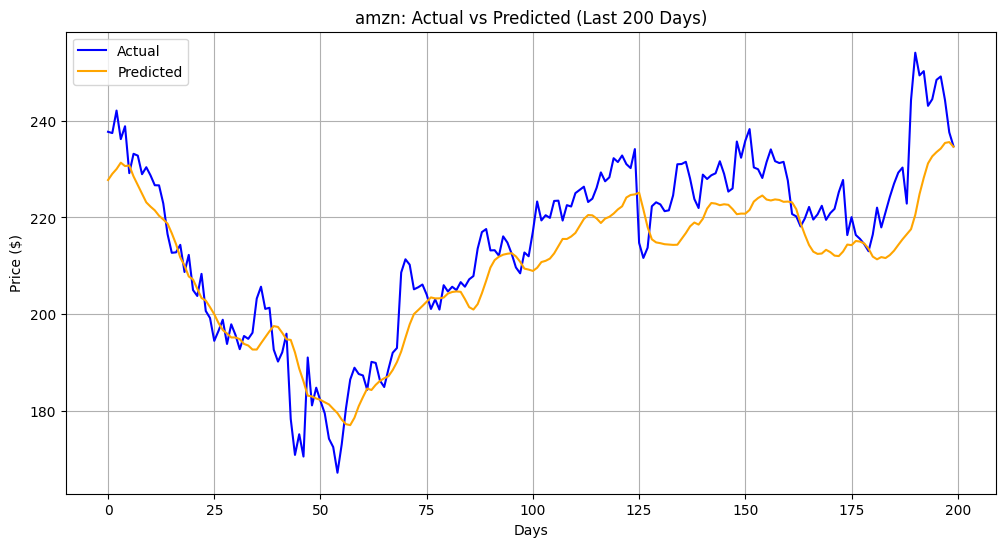

In [144]:
# PLOT: Actual vs Predicted (Last 200 Days)
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[-200:], label='Actual', color='blue')
plt.plot(y_pred[-200:], label='Predicted', color='orange')
plt.title(f'{ticker}: Actual vs Predicted (Last 200 Days)')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

Enter Future Date (YYYY-MM-DD): 2025-11-20

Predicting 6 days ahead to 2025-11-20...

amzn Prediction: 2025-11-14 → 2025-11-20
Date         Price      Change     Trend
----------------------------------------
2025-11-17   $233.06    -1.63     DOWN
2025-11-18   $214.37    -18.70     DOWN
2025-11-19   $190.68    -23.68     DOWN
2025-11-20   $164.86    -25.82     DOWN


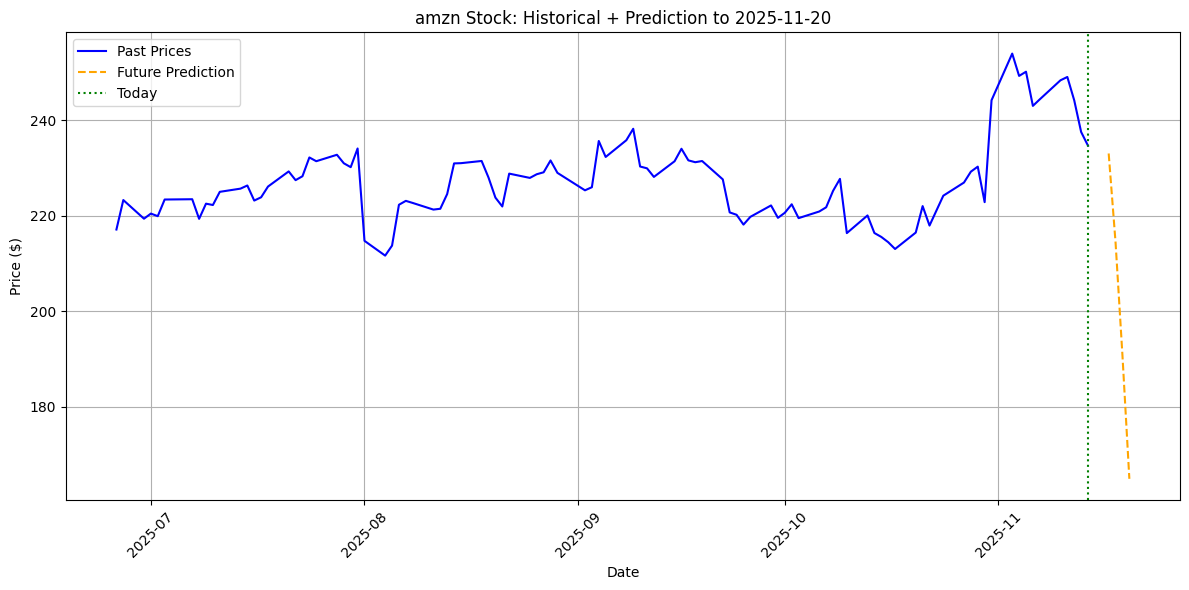

In [145]:
future_date_str = input("Enter Future Date (YYYY-MM-DD): ")
future_date = pd.to_datetime(future_date_str).date()
# FUTURE PREDICTION (From Today to User Date)
last_date = data.index[-1].date()
current_price = data['Close'].iloc[-1]

if future_date <= last_date:
    print("Future date must be after today!")
else:
    days_ahead = (future_date - last_date).days
    print(f"\nPredicting {days_ahead} days ahead to {future_date}...")

    last_seq = scaled_data[-60:].copy()
    future_preds = []
    current_seq = last_seq

    for _ in range(days_ahead):
        pred = model.predict(current_seq.reshape(1, 60, len(features)), verbose=0)[0, 0]
        future_preds.append(pred)

        # Update sequence with realistic dummy features
        new_close = pred
        new_sma10 = np.mean(np.append(current_seq[-9:, 0], new_close)) if len(current_seq) >= 9 else new_close
        new_sma50 = np.mean(current_seq[-50:, 0]) # Corrected to directly take mean of last 50
        new_ema12 = 0.6 * new_close + 0.4 * current_seq[-1, 3]
        new_ema26 = 0.3 * new_close + 0.7 * current_seq[-1, 4]
        new_rsi = 50  # Neutral
        new_macd = new_ema12 - new_ema26
        new_signal = 0.5 * new_macd + 0.5 * current_seq[-1, 7]

        new_row = np.array([[new_close, new_sma10, new_sma50, new_ema12, new_ema26, new_rsi, new_macd, new_signal]])
        new_row_scaled = scaler.transform(new_row)
        current_seq = np.vstack([current_seq[1:], new_row_scaled])

    # Inverse transform
    future_prices = scaler.inverse_transform(
        np.concatenate([np.array(future_preds).reshape(-1,1), np.zeros((len(future_preds), len(features)-1))], axis=1)
    )[:, 0]

    # Generate business dates
    pred_dates = pd.bdate_range(start=last_date + timedelta(days=1), end=future_date)
    future_prices = future_prices[:len(pred_dates)]

    # PRINT TABLE WITH UP/DOWN
    print(f"\n{ticker} Prediction: {last_date} → {future_date}")
    print(f"{'Date':<12} {'Price':<10} {'Change':<10} {'Trend'}")
    print("-" * 40)
    prev = current_price
    for d, p in zip(pred_dates, future_prices):
        change = p - prev
        trend = "UP" if change > 0 else "DOWN"
        color = "\033[92m" if trend == "UP" else "\033[91m"
        print(f"{d.strftime('%Y-%m-%d'):<12} ${p:<9.2f} {change:+.2f}     {color}{trend}\033[0m")
        prev = p

    # FINAL PLOT
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'][-100:], label='Past Prices', color='blue')
    plt.plot(pred_dates, future_prices, label='Future Prediction', color='orange', linestyle='--')
    plt.axvline(x=last_date, color='green', linestyle=':', label='Today')
    plt.title(f'{ticker} Stock: Historical + Prediction to {future_date}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()